In [440]:
import os
import gzip
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

First example is number 5


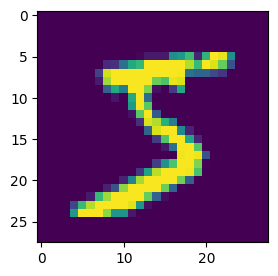

In [471]:
def prepare_mnist(path='mnist_data'):
  base_url = 'http://yann.lecun.com/exdb/mnist/'
  files = [
      'train-images-idx3-ubyte.gz',
      'train-labels-idx1-ubyte.gz',
      't10k-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz'
  ]

  if not os.path.exists(path):
      os.makedirs(path)

  for file in files:
    if not os.path.exists(os.path.join(path, file)):
      urllib.request.urlretrieve(base_url + file, os.path.join(path, file))

  def load_image(filename, offset):
    with gzip.open(filename, 'rb') as f:
      data = np.frombuffer(f.read(), np.uint8, offset=offset)
    return data
      
  X = load_image(f'{path}/train-images-idx3-ubyte.gz', 16).reshape(-1, 28, 28)
  y = load_image(f'{path}/train-labels-idx1-ubyte.gz', 8)
  X_test = load_image(f'{path}/t10k-images-idx3-ubyte.gz', 16).reshape(-1, 28, 28)
  y_test = load_image(f'{path}/t10k-labels-idx1-ubyte.gz', 8)

  # plot the first example image
  print(f"First example is number {y[0]}")
  plt.figure(figsize=(3, 3))
  plt.imshow(X[0])
  return X, y, X_test, y_test

X, y, X_test, y_test = prepare_mnist()

In [472]:
# split to traning and dev set (50 000 train, 10 000 dev and 10 000 test set)
split_idx = 50000
seed = 42
np.random.seed(seed)
idxs = np.arange(X.shape[0])
np.random.shuffle(idxs)
X, y = X[idxs], y[idxs]
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# convert to pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 28*28)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 28*28)
y_val = torch.tensor(y_val, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 28*28)
y_test = torch.tensor(y_test, dtype=torch.int64)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [473]:
# hyperparameters
input_dim = 28*28
output_dim = 10
hidden_dim = 512
lr = 0.001
epochs = 1000
batch_size = 64

In [474]:
class SimpleNeural_network(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(SimpleNeural_network, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [475]:
model = SimpleNeural_network(input_dim, hidden_dim, output_dim)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# training loop
for epoch in range(epochs):
  # mini-batch
  ixs = np.random.randint(X_train.shape[0], size=batch_size)
  xs = X_train[ixs]
  ys = y_train[ixs]
  
  # reset the gradient
  optimizer.zero_grad()
  
  # forward pass
  probs = model(xs)
  loss = criterion(probs, ys)
  accuracy = (torch.argmax(probs, dim=1) == ys).float().mean()
  
  # bacward pass
  loss.backward()
  optimizer.step()
  
  # validation
  with torch.no_grad():
    val_probs = model(X_val)
    val_loss = criterion(val_probs, y_val)
    val_accuracy = (torch.argmax(val_probs, dim=1) == y_val).float().mean()
  
  # print logs
  if epoch % 50 == 0:
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}, \
Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}")


Epoch [1/1000], Loss: 30.1231, Accuracy: 0.1406, Val Loss: 61.0467, Val Accuracy: 0.2026
Epoch [51/1000], Loss: 1.5318, Accuracy: 0.7812, Val Loss: 1.0546, Val Accuracy: 0.8397
Epoch [101/1000], Loss: 0.4650, Accuracy: 0.9219, Val Loss: 0.7402, Val Accuracy: 0.8697
Epoch [151/1000], Loss: 0.5333, Accuracy: 0.8906, Val Loss: 0.5625, Val Accuracy: 0.8900
Epoch [201/1000], Loss: 0.8658, Accuracy: 0.8906, Val Loss: 0.5258, Val Accuracy: 0.8916
Epoch [251/1000], Loss: 0.3240, Accuracy: 0.9375, Val Loss: 0.4581, Val Accuracy: 0.9009
Epoch [301/1000], Loss: 0.6325, Accuracy: 0.9062, Val Loss: 0.3976, Val Accuracy: 0.9120
Epoch [351/1000], Loss: 0.6305, Accuracy: 0.9062, Val Loss: 0.3802, Val Accuracy: 0.9105
Epoch [401/1000], Loss: 0.1799, Accuracy: 0.9688, Val Loss: 0.3417, Val Accuracy: 0.9213
Epoch [451/1000], Loss: 0.0793, Accuracy: 0.9688, Val Loss: 0.3411, Val Accuracy: 0.9250
Epoch [501/1000], Loss: 0.4848, Accuracy: 0.8906, Val Loss: 0.3245, Val Accuracy: 0.9218
Epoch [551/1000], Loss

Most predicted:  6
Less predicted:  9
Ground truth:    6


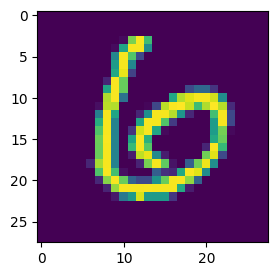

In [476]:
exm = 11
plt.figure(figsize=(3, 3))
plt.imshow(X_test[exm].reshape(28, 28))
print("Most predicted: ", torch.argmax(model(X_test[exm].reshape(1, -1))).item())
print("Less predicted: ", torch.argmin(model(X_test[exm].reshape(1, -1))).item())
print("Ground truth:   ", y_test[exm].item())

In [477]:
# accuracy and loss on the test set 
test_preds = model(X_test)
test_loss = criterion(test_preds, y_test)
test_accuracy = (torch.argmax(test_preds, dim=1) == y_test).float().mean()
print(f"{test_loss=}")
print(f"{test_accuracy=}")

test_loss=tensor(0.2508, grad_fn=<NllLossBackward0>)
test_accuracy=tensor(0.9389)


In [478]:
model(X_test[exm].reshape(1, -1)).reshape(-1).detach().numpy()

array([-2.26287346e+01, -1.09510708e+01, -1.42644539e+01, -2.15345211e+01,
       -2.14933014e+01, -1.31102295e+01, -6.85429914e-05, -2.73662834e+01,
       -9.93632126e+00, -3.11758137e+01], dtype=float32)

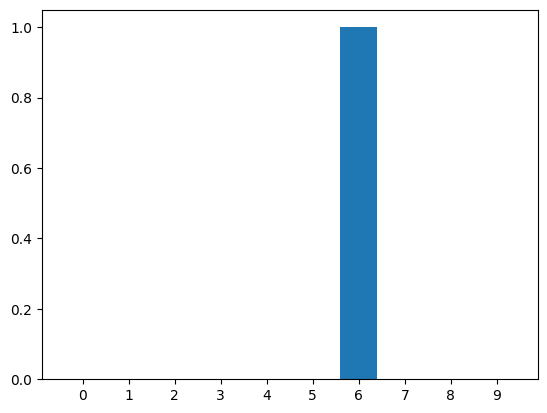

In [479]:
plt.bar(range(0, 10), np.exp(model(X_test[exm].reshape(1, -1)).reshape(-1).detach().numpy()));
plt.xticks(range(0, 10));

In [480]:
# calculating the uncertainity
                    # forward pass probs                   # ground truth                   # for all xs
losses = [criterion(model(X_test[i].reshape(1, -1)), y_test[i].reshape(1)).item() for i in range(X_test.shape[0])]
losses = np.array(losses)
len(losses)

10000

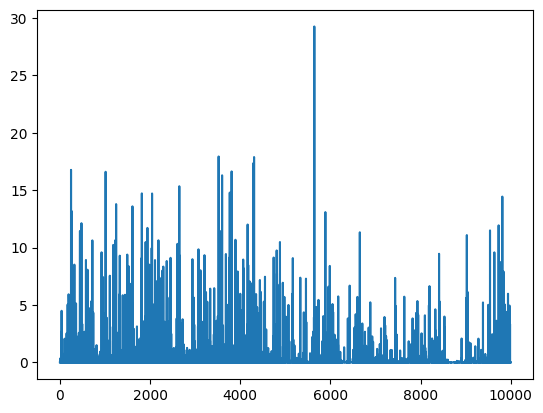

In [481]:
plt.plot(losses);

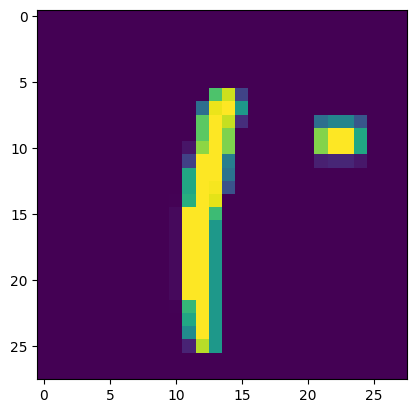

In [482]:
# most uncertained picture
plt.imshow(X_test[np.argmax(losses)].reshape(28, 28));

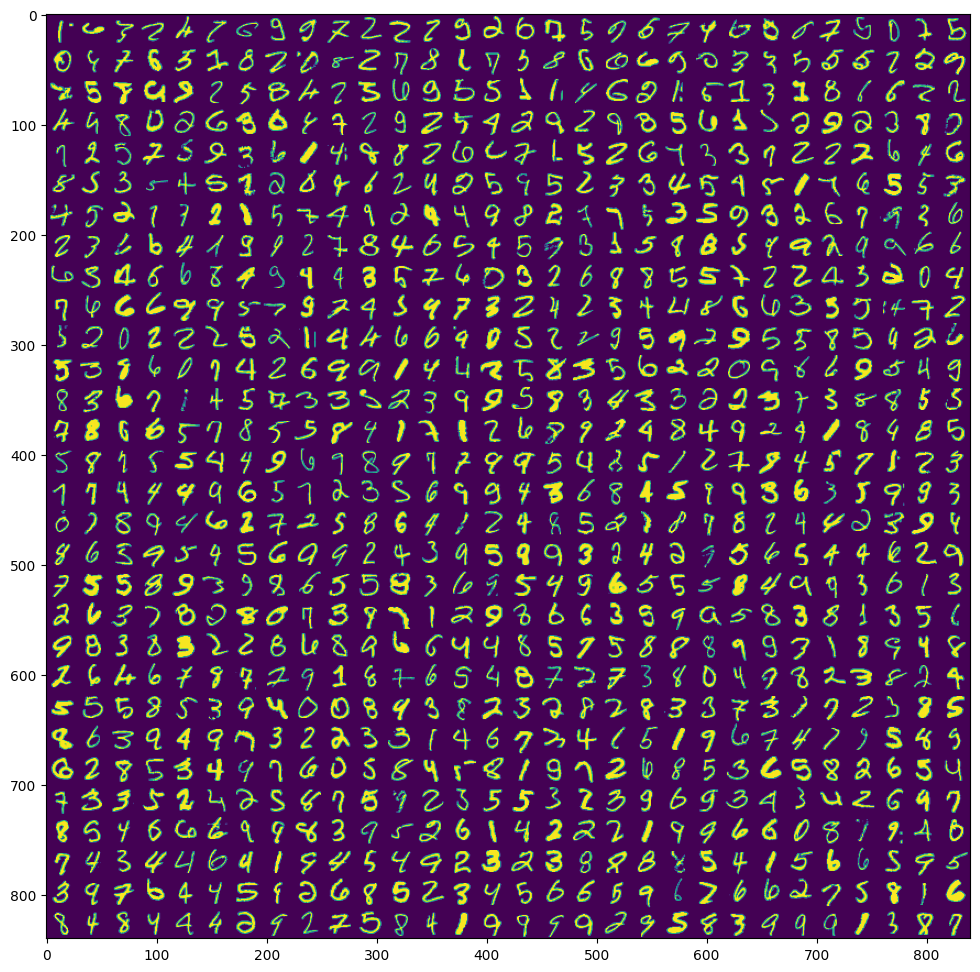

In [483]:
# computational power huh :D
N = 30
# array[-N*N:] --> equivalent to the --> array[::-1][:N*N]
idxs = np.argsort(losses)[::-1][:N*N] # first N uncertain images
# to see least uncertain images, delete `[::-1]`
images = [X_test[i].reshape(28, 28) for i in idxs] # reshape each img to 28x28
grid = np.concatenate(
  [np.concatenate(images[i*N : (i+1)*N], axis=1) for i in range(N)], # concat cols
  axis=0                                                             # concat rows
)
plt.figure(figsize=(12, 12))
plt.imshow(grid);

In [484]:
# convert back to numpy ndarray
X_test = X_test.numpy()
y_test = y_test.numpy()

In [485]:
# forward pass in numpy
def forward():
  # copying the weights from pytorch
  fc1 = model.fc1.weight.detach().numpy().T
  fc2 = model.fc2.weight.detach().numpy().T
  x = X_test @ fc1 # first pre activation
  x = np.maximum(0, x) # relu activation
  x = x @ fc2 # second hidden layer
  # apply log softmax
  exps = np.exp(x - x.max(axis=1, keepdims=True)) # prevent overflow
  exps = exps / np.sum(exps, axis=1, keepdims=True) # normalize
  exps = np.log(exps) # apply natural logarithm
  return exps
  
output = forward()

In [487]:
# numpy and torch accuracy matches
# pytorch loss was     --> 0.2508
# pytorch accuracy was --> 0.9389
np_accuracy = (np.argmax(output, axis=1) == y_test).astype(np.float32).mean()
np_loss = -output[np.arange(output.shape[0]), y_test].mean()
print(f"{np_accuracy=:.4f}")
print(f"{np_loss=:.4}")

np_accuracy=0.9391
np_loss=0.2508


In [490]:
# now real challenge :D, do the backprop with numpy only